### Setup

In [1]:
!pip install -q yt-dlp==2025.5.22 \
                opencv-python==4.11.0.86

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.5 MB/s eta 0:00:00


In [2]:
from yt_dlp import YoutubeDL
import os
import re
import tempfile
import cv2
import numpy as np
import requests
import base64

In [3]:
from google import genai
from google.genai import types

### Utils

In [4]:
def get_subtitle_content(subtitle_url, include_time = False):

  subtitles = []
  subtitle_text = ""

  response = requests.get(subtitle_url)
  data = response.json()

  for event in data.get("events", []):
      if "segs" in event:
          start = event.get("tStartMs", 0) / 1000.0
          duration = event.get("dDurationMs", 0) / 1000.0
          text = "".join(seg.get("utf8", "") for seg in event["segs"])
          subtitles.append({
              "start": start,
              "duration": duration,
              "text": text.strip()
          })

  for sub in subtitles:
    if include_time:
      subtitle_text += f"[{sub['start']:.1f}-{sub['start'] + sub['duration']:.1f}]"
    subtitle_text += sub['text']
    subtitle_text += "\n"

  return subtitle_text

In [5]:
def process_video_metadata(video_metadata):

  metadata_description = ""
  fields_of_interest = ["title", "description","categories","tags"]
  for field in fields_of_interest:
    if video_metadata.get(field):
      metadata_description +=f"**{field.upper()}**: {str(video_metadata.get(field))} \n\n"

  if video_metadata.get('subtitles'):
    subtitles = video_metadata.get('subtitles')
    if subtitles.get('en'):
      english_subtitles = subtitles.get('en')
      formatted_version = english_subtitles[0]
      if formatted_version.get("ext") == "json3":
        subtitle_text = get_subtitle_content(formatted_version.get("url"))
        metadata_description +=f"**SUBTITLES**: {subtitle_text} \n\n"
      else:
        print("Unable to find json3 version for subtitles.")
    else:
      print("Subtitles not found for english language.")
  else:
    metadata_description +=f"**SUBTITLES**: N/A"

  return metadata_description

In [6]:
def generate_snapshots(video_path, num_snapshots=5, output_dir = "snapshots"):

  print(f"\n--- Taking Snapshots for: {video_path} ---")
  snapshots_filepath = []

  if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created parent directory for snapshots: {output_dir}")

  video_name = os.path.splitext(os.path.basename(video_path))[0]
  video_snapshot_dir = os.path.join(output_dir, video_name)

  if not os.path.exists(video_snapshot_dir):
    os.makedirs(video_snapshot_dir)
    print(f"Created directory for video snapshots: {video_snapshot_dir}")

  cap = cv2.VideoCapture(video_path)

  if not cap.isOpened():
    print(f"Error: Could not open video file {video_path} with OpenCV.")
    if os.path.exists(video_path): # Clean up downloaded file if it exists
        try:
            os.remove(video_path)
            print(f"Cleaned up temporary video file: {video_path}")
        except OSError as e:
            print(f"Error deleting temporary file {video_path}: {e}")
    return

  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print(f"Total frames in video: {total_frames}")

  frame_indices = np.linspace(0, total_frames - 1, num=num_snapshots, dtype=int)

  for i, frame_id in enumerate(frame_indices):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    if ret:
      snapshot_filename = os.path.join(video_snapshot_dir, f"snapshot_{i+1}.png")
      cv2.imwrite(snapshot_filename, frame)
      print(f"Saved snapshot: {snapshot_filename} (from frame {frame_id})")
      snapshots_filepath.append(snapshot_filename)
    else:
      print(f"Error reading frame {frame_id} for snapshot {i+1}.")

  cap.release()
  print("\nSnapshot process complete.")

  # Clean up the downloaded video file from the temp directory
  if os.path.exists(video_path):
    try:
        os.remove(video_path)
        print(f"Cleaned up temporary video file: {video_path}")
    except OSError as e:
        print(f"Error deleting temporary file {video_path}: {e}")

  return snapshots_filepath

In [7]:
def clean_title(title_str):

  title = re.sub(r'[\\/*?:"<>|]', '_', title_str) # special chars
  title = re.sub(r'[^\x00-\x7F]+', '', title) # no ascii
  title = re.sub(r'\s+', '_', title) # whitespaces
  title = re.sub(r'_+', '_', title) # collapse multiple underscores
  title = title.strip('_') # trim underscores

  return title

In [8]:
def get_video_data(url, min_duration = 120, download_dir = "downloads"):

  with YoutubeDL() as ydl:
    info_dict = ydl.extract_info(url, download=False)
    if 'title' in info_dict and isinstance(info_dict['title'], str):
      title = clean_title(info_dict['title'])

    if 'duration' in info_dict and isinstance(info_dict['duration'], int):
      video_duration = info_dict['duration']

      if video_duration < min_duration:

        print("Shorter video, using mp4 file directly")
        if not os.path.exists(download_dir):
          os.makedirs(download_dir)
          print(f"Created downloads directory: {download_dir}")

        file_path = os.path.abspath(f"downloads/{title}.mp4")
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
            'outtmpl': file_path,
            'quiet': False,
            'no_warnings': True,
            'noplaylist': True,
        }

        with YoutubeDL(ydl_opts) as ydl_download:
            ydl_download.download([url])

        return info_dict, file_path
      elif video_duration > min_duration and video_duration < 1800:

        print("Longer video, downloading mp4 file and generating snapshots")
        file_path = os.path.join(tempfile.gettempdir(), f"{title}.mp4")
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
            'outtmpl': file_path,
            'quiet': False,
            'no_warnings': True,
            'noplaylist': True,
        }

        with YoutubeDL(ydl_opts) as ydl_download:
            ydl_download.download([url])

        media_path = generate_snapshots(file_path)

        return info_dict, media_path
      else:
        print("Video is longer than 1 hour, skipping")
        return None, None
    else:
      print("Video duration not found, skipping")
      return None, None

In [24]:
def get_file_data(file_path):
    """Convert file data to base64"""
    try:
        # file.seek(0)
        file_content = open(file_path, 'rb').read()
        file_data = base64.b64encode(file_content).decode("utf-8")
        return file_data
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

### Generation

In [172]:
video_url = "https://youtu.be/2lAe1cqCOXo?si=lQlS9vEbDOYkGbpW"
# video_url = "https://youtu.be/u_Gm_Hi7gV4"
video_metadata, media_path = get_video_data(video_url)

[youtube] Extracting URL: https://youtu.be/2lAe1cqCOXo?si=lQlS9vEbDOYkGbpW
[youtube] 2lAe1cqCOXo: Downloading webpage
[youtube] 2lAe1cqCOXo: Downloading tv client config
[youtube] 2lAe1cqCOXo: Downloading tv player API JSON
[youtube] 2lAe1cqCOXo: Downloading ios player API JSON
[youtube] 2lAe1cqCOXo: Downloading m3u8 information
Longer video, downloading mp4 file and generating snapshots
[youtube] Extracting URL: https://youtu.be/2lAe1cqCOXo?si=lQlS9vEbDOYkGbpW
[youtube] 2lAe1cqCOXo: Downloading webpage
[youtube] 2lAe1cqCOXo: Downloading tv client config
[youtube] 2lAe1cqCOXo: Downloading tv player API JSON
[youtube] 2lAe1cqCOXo: Downloading ios player API JSON
[youtube] 2lAe1cqCOXo: Downloading m3u8 information
[info] 2lAe1cqCOXo: Downloading 1 format(s): 616+140
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 66
[download] Destination: /tmp/YouTube_Rewind_2019_For_the_Record_#YouTubeRewind.f616.mp4
[download] 100% of  136.49MiB in 00:00:09 at 14.59MiB/s            

In [11]:
# process_video_metadata(video_metadata)

In [ ]:
client = genai.Client(api_key="API-KEY")

In [91]:
system_instruction = """You are an expert YouTube Video Analyst and Thumbnail Description Specialist.
Your primary objective is to meticulously analyze the provided data for a YouTube video and generate a concise, compelling, and visually-oriented description. This description will directly inform the creation of an engaging YouTube thumbnail.

**You will be provided with one or more of the following data sources:**
* **Video Title:** The official title of the video.
* **Video Description:** The text description accompanying the video.
* **Video Metadata:** Tags, categories, and other relevant metadata.
* **Subtitles/Transcript:** The textual content of the spoken audio.
* **Visual Content (if available):** This may include the full video, specific snapshots, or keyframes from the video.

**Your Core Task:**
Based *solely* on the provided data sources, generate a high-level summary that vividly describes the video's essence. This summary must highlight the most visually striking and thematically important elements suitable for a thumbnail.

**Key Requirements for Your Description:**
1.  **Thumbnail-Focused:** Prioritize details that can be visually represented in a thumbnail. Think about:
    * **Main Subject(s):** Who or what is the central focus? (e.g., a person, an object, an animal, a place).
    * **Key Action/Activity:** What is the most significant action or event occurring? (e.g., someone cooking, a car racing, a product being unboxed, a landscape being revealed, a chat interface, an app screen).
    * **Visually Salient Elements:** Are there any prominent objects, colors, settings, or expressions that stand out, especially if visual content is provided?
    * **Core Emotion/Vibe (if discernible):** Does the video aim to be exciting, informative, funny, mysterious, etc.? This can influence thumbnail design.
2.  **Concise and Impactful:** The description should be brief (e.g., 3-6 sentences) yet powerful enough to convey the video's core appeal.
3.  **Simple and Clear:** Use language that is easy to understand at a glance. Avoid jargon/techincal details unless it's central to the video's topic and likely known by the target audience.
4.  **Accurate to Provided Data:** Strictly adhere to the information given. Do not infer, imagine, or add any external information not present in the source data.
5.  **Highlight Key Features:** Ensure the description captures the unique selling points or most interesting aspects of the video that would entice a click.

**Output Format:**
Provide a single, coherent paragraph.

**Example Thought Process when generating the description:**
*If the video is a "How to Bake a Chocolate Cake" tutorial and I have snapshots showing a rich, melting chocolate drizzle on a finished cake, and the title mentions "Decadent Chocolate Cake," I should emphasize "A close-up of a decadent chocolate cake being drizzled with glossy chocolate ganache, highlighting its rich texture." rather than just "A cooking tutorial about cakes."*

"""

In [173]:
def get_gemini_response(contents):

  response = client.models.generate_content(
      model="gemini-2.0-flash-001",
      config=types.GenerateContentConfig(
          system_instruction=system_instruction,
          temperature=0.2,
          max_output_tokens=1024
      ),
      contents=contents,
  )

  return response.text

In [174]:
def construct_contents(video_metadata, media_path):
  if isinstance(media_path, str):
    print("Processing video file")
    contents = [
        f"Video Metadata: {process_video_metadata(video_metadata)}",
        "Video file:",
        types.Part(
            inline_data=types.Blob(data=get_file_data(media_path), mime_type='video/mp4')
        ),
        "Description:"
    ]
  elif isinstance(media_path, list):
    print("Processing snapshots")
    contents = [
        f"Video Metadata: {process_video_metadata(video_metadata)}",
        "Snapshots of video:"
    ]
    for snapshot_image in media_path:
      contents.append(
          types.Part.from_bytes(
            data=get_file_data(snapshot_image),
            mime_type=f'image/{snapshot_image.split(".")[-1]}',
          ),
      )
    contents.append("Description:")
  print("Contents length",len(contents))
  return contents

In [175]:
message_content = construct_contents(video_metadata, media_path)

Processing snapshots
Contents length 8


In [177]:
video_description_big = get_gemini_response(message_content)

In [182]:
video_description_big

'YouTube Rewind 2019 celebrates the top creators, music, and moments of the year, focusing on what viewers *did* like. The video highlights the most liked creator videos, featuring creators like Shane Dawson, James Charles, and MrBeast. It also showcases top music videos from artists like Billie Eilish, Ariana Grande, and BLACKPINK, along with popular dance videos and the most viewed video games like Minecraft and Fortnite. The rewind also features new, breakout creators and the most viewed creators of the year, including PewDiePie and David Dobrik.'

In [94]:
# Shorter videos
message_content = construct_contents(video_metadata, media_path)

Processing video file
Contents length 4


In [95]:
video_description = get_gemini_response(message_content)

In [96]:
video_description

'This video showcases a simple RAG chatbot demo built with Mesop UI and LangGraph for workflow management, utilizing Google AI studio API keys and Gemini models. The video displays a chat interface where a user interacts with the bot, asking questions about AI agents and recipes. The bot then retrieves relevant information from linked PDF documents, providing answers and sources. The thumbnail could highlight the chat interface with example questions and answers, or a visual representation of the workflow orchestration with LangGraph.'

In [161]:
generate_imagen_prompt = """You are an expert Visual Prompt Engineer, specializing in crafting prompts for Google's Imagen model to generate captivating YouTube thumbnails.
You will be provided with a descriptive summary of a YouTube video (this summary was created to highlight key visual and thematic elements suitable for a thumbnail).

Your primary task is to transform this video summary into a concise yet detailed Imagen prompt. The prompt should guide Imagen to create an image that is:
* Visually striking and attention-grabbing.
* Clearly representative of the video's core subject or theme.
* Effective as a small thumbnail (clear focal point, good contrast).
* Aesthetically pleasing and aligned with common YouTube thumbnail styles (e.g., vibrant, dramatic, clean, illustrative, photorealistic, etc., as appropriate).

**Key Steps and Considerations for Crafting the Imagen Prompt:**

1.  **Identify Core Visuals:** From the input description, extract the most important tangible subjects, objects, characters, and environments.
2.  **Translate Concepts to Imagery:**
    * Abstract ideas (e.g., "security," "speed," "learning") should be translated into visual metaphors or symbolic representations (e.g., "shield icon," "motion blur," "glowing brain/book").
    * "Technical details" should be omitted unless they can be compellingly visualized (e.g., "circuit board patterns" for tech, "stylized data streams").
3.  **Define Composition and Framing:**
    * Specify the main focal point.
    * Suggest camera angles or shot types (e.g., "close-up," "dynamic low-angle shot," "wide shot," "macro").
    * Indicate subject placement if important (e.g., "centered," "subject on the left facing right").
4.  **Incorporate Artistic Style and Atmosphere:**
    * Suggest relevant artistic styles: "photorealistic," "digital painting," "cinematic," "flat illustration," "3D render," "anime style," "graphic design," "hyperrealistic."
    * Define lighting: "dramatic lighting," "studio lighting," "soft natural light," "glowing aura," "backlit."
    * Suggest color palettes or moods: "vibrant contrasting colors," "monochromatic with a pop of color," "dark and moody," "bright and cheerful."
5.  **Minimize In-Image Text Generation:**
    * **Crucial:** Image generation models often struggle to render legible text accurately. **Avoid prompting for specific words or sentences to be part of the generated image.**
    * Instead, if text is implied or needed:
        * Prompt for **UI elements** where text could logically appear (e.g., "a clean, modern user interface with blank buttons and panels," "a character holding a blank sign," "a futuristic display screen showing abstract data patterns instead of text").
        * Describe **graphic elements or spaces** suitable for text overlay later (e.g., "a smooth banner across the top," "a circular area with a simple border").
        * Use **iconography or symbols** to represent concepts that might otherwise be text (e.g., a "play button icon" instead of the word "Play").
6.  **Add Enhancing Details:** Include specific adjectives and descriptive phrases that add richness and guide the image generation (e.g., "glossy texture," "intricate details," "futuristic interface," "ancient artifact").

**Instructions:**
* Analyze the provided video summary.
* Do NOT simply copy phrases from the input. Reinterpret and rephrase for visual generation.
* **STRICTLY limit requests for actual text to be rendered within the image.** Focus on visual elements, UI components, and placeholders.
* Think like a thumbnail designer.
* Do NOT include technical jargons or words that are not related to styling or visual content. Be as vague as possible, when it comes to technical details.

**Example (Illustrating the Transformation & Text Handling):**

* **Input Video Summary:** "Video explains how to use a new productivity app, highlighting its simple interface, task management features, and calendar integration. The app is called 'ZenTask'."
* **Generated Imagen Prompt (No direct text for 'ZenTask'):** "Clean and minimalist user interface of a productivity app, showcasing stylized checklist icons, abstract calendar-like grids, and smooth, empty panels. Soft pastel color palette, digital art style. Focus on clarity and ease of use, with prominent, empty button shapes. No visible text."

* **Original Example (for context):**
  * **Input Video description:** "Video is about a personal e-wallet that is secure, has data in the cloud and very minimalistic. It has many screens and has ability securely act as a wallet."
  * **Generated Imagen prompt:** "Logo of an electronic wallet, with more emphasis on 'wallet' with elements like cloud and security, surrounded with a black and white background. Wallet is located in the middle, with neural nets or circuits spreading from the wallet, outwards..." (Note: "Logo" implies a graphic, not necessarily text).

Now, based on the video summary provided, generate the Imagen prompt.
"""

In [162]:
def get_imagen_prompt(video_description):

  response = client.models.generate_content(
      model="gemini-2.0-flash-001",
      # model="gemini-2.5-flash-preview-05-20",
      config=types.GenerateContentConfig(
          system_instruction=generate_imagen_prompt,
          temperature=0.2,
          max_output_tokens=1024
      ),
      contents=["Video Description:",video_description, "Imagen Prompt:"],
  )

  return response.text

In [163]:
imagen_prompt = get_imagen_prompt(video_description)

In [178]:
imagen_prompt_big = get_imagen_prompt(video_description_big)

In [179]:
imagen_prompt_big

'A vibrant collage representing the best of YouTube 2019. Feature a central, dynamic arrangement of stylized icons representing popular video categories: gaming controller (Minecraft/Fortnite), a music note (Billie Eilish/Ariana Grande/BLACKPINK), a camera (Shane Dawson/James Charles/MrBeast), and a rising star symbol (new creators). Surround the central arrangement with blurred, abstract shapes in bright, energetic colors, suggesting motion and excitement. Digital illustration style with a clean, modern aesthetic. Focus on positive and celebratory imagery. No text.\n'

In [100]:
imagen_prompt

'"Screenshot of a clean, modern chat interface with a question about AI agents and a concise answer from a chatbot, overlaid on a stylized LangGraph workflow diagram visualizing data flow. Gemini model logo subtly integrated. Vibrant, tech-inspired color palette, focus on clarity and readability. Digital illustration style."\n'

In [112]:
imagen_prompt

'"Clean and modern chat interface with stylized message bubbles showcasing example questions and answers about AI agents and recipes. A subtle, interconnected node graph representing workflow orchestration in the background, reminiscent of LangGraph. Use of the Gemini/Google AI logo subtly incorporated as a watermark or icon. Digital art style, bright and cheerful color palette with a focus on blues and greens. Emphasis on clarity and ease of use. No visible text within the chat bubbles, only suggestive shapes. A linked PDF document icon subtly placed near the answer section. "\n'

In [164]:
imagen_prompt

'A clean and modern chat interface, showcasing example questions and answers related to AI. The interface features a prominent input field and stylized chat bubbles with abstract text representing conversation. In the background, a subtle, interconnected graph visualization symbolizes workflow orchestration. Use a vibrant color palette with a focus on blues and greens to convey a sense of technology and intelligence. Digital art style with a slightly futuristic aesthetic. Focus on clarity and visual appeal, with a smooth banner across the top for potential title overlay. No visible brand names or logos.\n'

In [131]:
edited_prompt = """Clean and modern chat interface with stylized message bubbles showcasing example conversation between user and AI.
A subtle, interconnected node graph representing workflow orchestration in the background, reminiscent of Graph.
Use of the AI logo subtly incorporated as a watermark or icon. Digital art style, bright and cheerful color palette with a focus on black and white.
Emphasis on clarity and ease of use. No visible text within the chat bubbles, only suggestive shapes.
A linked PDF document icon subtly placed near the answer section.
**Avoid Generating text anywhere in the image**"""

In [165]:
def generate_image(prompt):

  response = client.models.generate_content(
      model="gemini-2.0-flash-preview-image-generation",
      config = types.GenerateContentConfig(
              response_modalities=[
                  "IMAGE",
                  "TEXT"
              ],
              response_mime_type="text/plain",
      ),
      contents=[prompt]
  )
  # print(response)
  return response

In [180]:
response = generate_image(imagen_prompt_big)

In [167]:
import mimetypes

def save_binary_file(file_name, data):
    f = open(file_name, "wb")
    f.write(data)
    f.close()
    print(f"File saved to to: {file_name}")

In [181]:
inline_data = response.candidates[0].content.parts[1].inline_data
data_buffer = inline_data.data
file_extension = mimetypes.guess_extension(inline_data.mime_type)
save_binary_file(f"image_v6{file_extension}", data_buffer)

File saved to to: image_v6.png


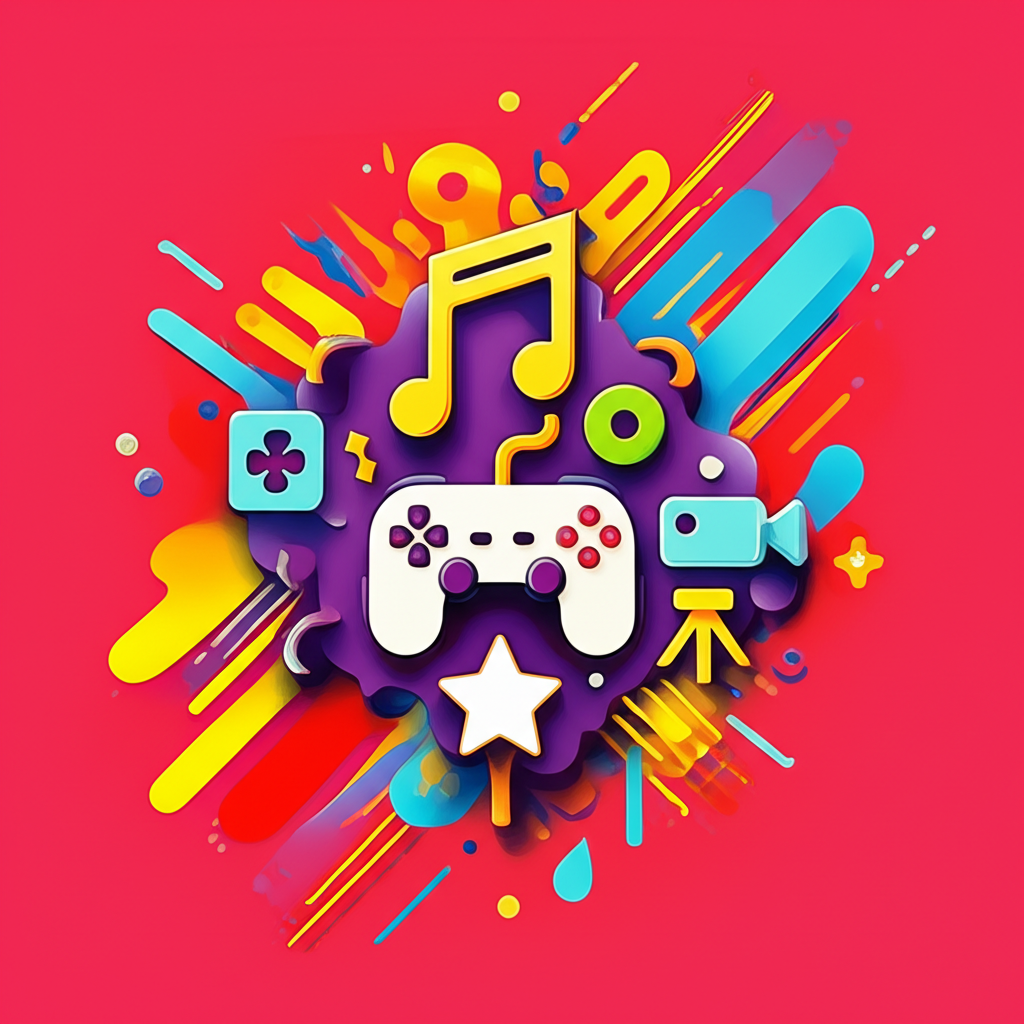

In [183]:
from IPython.display import Image
Image(filename='image_v6.png')